<div style="text-align: right"> Kevin Le </div>
<div style="text-align: right"> CSE 803 </div>
<div style="text-align: right"> Hw5 </div>

## Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # Displays a progress bar

import torch
from torch import nn
from torch import optim, Tensor
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, Subset, DataLoader, random_split

import png
from colormap.colors import Color, hex2rgb
from sklearn.metrics import average_precision_score as ap_score
import os
from PIL import Image
import time

c:\Users\Kevin Le\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Fashion-MNIST Classification

The dataset we use is Fashion-MNIST dataset, which is available at https://github.com/zalandoresearch/
fashion-mnist and in torchvision.datasets. Fashion-MNIST has 10 classes, 60000 training+validation
images (we have splitted it to have 50000 training images and 10000 validation images, but you can change
the numbers), and 10000 test images. We have provided some starter code in part1.py where you need
to modify and experiment with the following:

* The architecture of the network (define layers and implement forward pass)
* The optimizer (SGD, RMSProp, Adam, etc.) and its parameters. (weight decay is the L2 regularization strength)
* Training parameters (batch size and number of epochs)

You should train your network on training set and change those listed above based on evaluation on the
validation set. You should run evalution on the test set only once at the end.

Complete the following:
1. Submit a program which trains with your best combination of model architecture, optimizer and
training parameters, and evaluates on the test set to report an accuracy at the end. (15 pts)
2. Report the detailed architecture of your best model. Include information on hyperparameters chosen
for training and a plot showing both training and validation loss across iterations. (10 pts)
3. Report the accuracy of your best model on the test set. We expect you to achieve over 90%. (10 pts)

In [360]:
# Load the dataset and train, val, test splits
print("Loading datasets...")
FASHION_transform = transforms.Compose([
    transforms.ToTensor(), # Transform from [0,255] uint8 to [0,1] float
    transforms.Normalize([0.2859], [0.3530]) # Normalize to zero mean and unit variance
])
FASHION_trainval = datasets.FashionMNIST('.', download=True, \
    train=True, transform=FASHION_transform)
FASHION_train = Subset(FASHION_trainval, range(50000))
FASHION_val = Subset(FASHION_trainval, range(50000,60000))
FASHION_test = datasets.FashionMNIST('.', download=True, \
    train=False, transform=FASHION_transform)
print("Done!")

Loading datasets...
Done!


Reference LeNet Architecture: https://d2l.ai/chapter_convolutional-modern/alexnet.html

In [361]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels = 1,out_channels = 6, kernel_size=5, padding=2), nn.ReLU(), 
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels = 6,out_channels = 16, kernel_size=5, padding=2), nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(28*28, 120, bias=True), nn.ReLU(), nn.Dropout(),
            nn.Linear(120, 84, bias=True), nn.ReLU(),nn.Dropout(),
            nn.Linear(84, 10, bias=True))

    def forward(self,x):
        x = self.net(x)
        return x

In [362]:
# Create dataloaders
trainloader = DataLoader(FASHION_train, batch_size=512, shuffle=True)
valloader = DataLoader(FASHION_val, batch_size=512, shuffle=True)
testloader = DataLoader(FASHION_test, batch_size=512, shuffle=True)
device = "cuda" if torch.cuda.is_available() else "cpu" # Configure device
model = Network().to(device)
criterion = nn.CrossEntropyLoss() # Specify the loss layer
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-10)
num_epoch = 30

In [363]:
def train(model, loader, num_epoch = 10): # Train the model
    print("Start training...")
    model.train() # Set the model to training mode
    total_loss = []
    total_acc = []
    for i in range(num_epoch):
        running_loss = []
        total = 0
        correct = 0
        for batch, label in tqdm(loader):
            batch = batch.to(device)
            label = label.to(device)
            optimizer.zero_grad() # Clear gradients from the previous iteration
            pred = model(batch) # This will call Network.forward() that you implement
            loss = criterion(pred, label) # Calculate the loss
            running_loss.append(loss.item())
            loss.backward() # Backprop gradients to all tensors in the network
            optimizer.step() # Update trainable weights
            
            _, predicted = pred.max(1)
            total += label.size(0)
            correct += predicted.eq(label).sum().item()
            accu = 100. * correct/total
            total_acc.append(accu)
        total_loss += running_loss
        print("Epoch {} loss:{}".format(i+1,np.mean(running_loss)))
    print("Done!")
    return total_loss, total_acc

def evaluate(model, loader): # Evaluate accuracy on validation / test set
    model.eval() # Set the model to evaluation mode
    correct = 0
    with torch.no_grad(): # Do not calculate grident to speed up computation
        for batch, label in tqdm(loader):
            batch = batch.to(device)
            label = label.to(device)
            pred = model(batch)
            correct += (torch.argmax(pred,dim=1)==label).sum().item()
    acc = correct/len(loader.dataset)
    print("Evaluation accuracy: {}".format(acc))
    return acc

In [364]:
loss_history, acc_history = train(model, trainloader, num_epoch)


Start training...


100%|██████████| 98/98 [00:13<00:00,  7.16it/s]


Epoch 1 loss:0.8728394131271207


100%|██████████| 98/98 [00:13<00:00,  7.18it/s]


Epoch 2 loss:0.5344539658755673


100%|██████████| 98/98 [00:14<00:00,  6.76it/s]


Epoch 3 loss:0.4591353067329952


100%|██████████| 98/98 [00:14<00:00,  6.59it/s]


Epoch 4 loss:0.42712489165821854


100%|██████████| 98/98 [00:15<00:00,  6.45it/s]


Epoch 5 loss:0.4019834691164445


100%|██████████| 98/98 [00:14<00:00,  6.59it/s]


Epoch 6 loss:0.3882845491170883


100%|██████████| 98/98 [00:15<00:00,  6.38it/s]


Epoch 7 loss:0.3752901624051892


100%|██████████| 98/98 [00:14<00:00,  6.96it/s]


Epoch 8 loss:0.3664280458980677


100%|██████████| 98/98 [00:13<00:00,  7.03it/s]


Epoch 9 loss:0.3586984389290518


100%|██████████| 98/98 [00:15<00:00,  6.36it/s]


Epoch 10 loss:0.35054217795936427


100%|██████████| 98/98 [00:15<00:00,  6.51it/s]


Epoch 11 loss:0.348541155761602


100%|██████████| 98/98 [00:14<00:00,  6.67it/s]


Epoch 12 loss:0.33954120016827877


100%|██████████| 98/98 [00:14<00:00,  6.84it/s]


Epoch 13 loss:0.3396487722591478


100%|██████████| 98/98 [00:14<00:00,  6.90it/s]


Epoch 14 loss:0.3357468838898503


100%|██████████| 98/98 [00:15<00:00,  6.42it/s]


Epoch 15 loss:0.3354458121620879


100%|██████████| 98/98 [00:13<00:00,  7.05it/s]


Epoch 16 loss:0.3253808118859116


100%|██████████| 98/98 [00:14<00:00,  6.66it/s]


Epoch 17 loss:0.32015205083452924


100%|██████████| 98/98 [00:14<00:00,  6.97it/s]


Epoch 18 loss:0.31832510445799145


100%|██████████| 98/98 [00:14<00:00,  6.94it/s]


Epoch 19 loss:0.31928050898167554


100%|██████████| 98/98 [00:13<00:00,  7.02it/s]


Epoch 20 loss:0.3079590624084278


100%|██████████| 98/98 [00:14<00:00,  6.96it/s]


Epoch 21 loss:0.30858348218762144


100%|██████████| 98/98 [00:14<00:00,  6.96it/s]


Epoch 22 loss:0.3111142821762027


100%|██████████| 98/98 [00:14<00:00,  6.74it/s]


Epoch 23 loss:0.30484273132621026


100%|██████████| 98/98 [00:14<00:00,  6.68it/s]


Epoch 24 loss:0.31712429453523794


100%|██████████| 98/98 [00:15<00:00,  6.50it/s]


Epoch 25 loss:0.3056552857160568


100%|██████████| 98/98 [00:15<00:00,  6.51it/s]


Epoch 26 loss:0.30569510405160943


100%|██████████| 98/98 [00:16<00:00,  6.06it/s]


Epoch 27 loss:0.3083297584433945


100%|██████████| 98/98 [00:15<00:00,  6.42it/s]


Epoch 28 loss:0.30232590969119755


100%|██████████| 98/98 [00:14<00:00,  6.75it/s]


Epoch 29 loss:0.29562244214573685


100%|██████████| 98/98 [00:14<00:00,  6.84it/s]

Epoch 30 loss:0.29640816197711595
Done!


In [365]:
print("Evaluate on validation set...")
evaluate(model, valloader)
print("Evaluate on test set")
evaluate(model, testloader)

Evaluate on validation set...


100%|██████████| 20/20 [00:02<00:00,  9.62it/s]


Evaluation accuracy: 0.9041
Evaluate on test set


100%|██████████| 20/20 [00:01<00:00, 10.39it/s]

Evaluation accuracy: 0.8986


0.8986

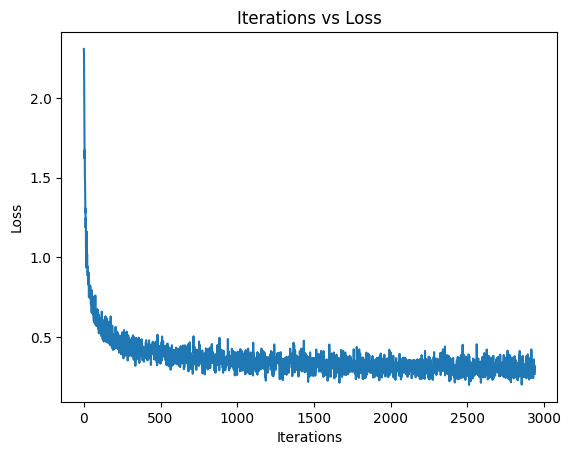

In [374]:
plt.plot(loss_history)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

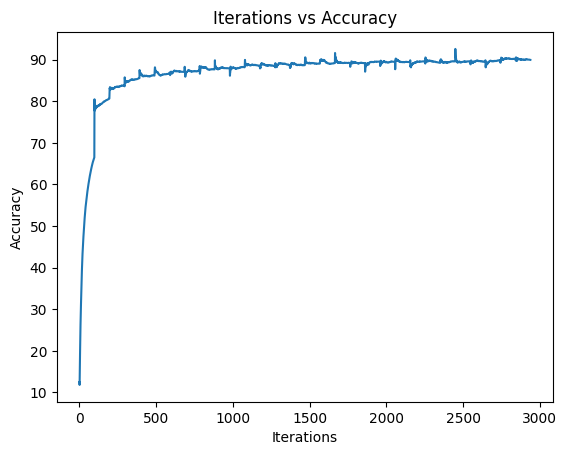

In [367]:
plt.plot(acc_history)
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.title("Iterations vs Accuracy")
plt.show()

Training Hyperparameters:
* Batch size = 512
* Learning Rate = $1e^{-2}$
* Decay Weight = $1e^{-10}$

* Number of Epoch = 30

Model was able to have ~90% accuracy while using the LeNet architecture

## Activation Visualization

To observe a meaningful pattern, we construct a custom dataset that localizes the Fashion-MNIST image
with the help of MNIST images. Each image in this new dataset will be a 2×2 grid of one Fashion-MNIST image and three MNIST images. The Fashion-MNIST image is placed at a random grid, where
the other three grids will be randomly-chosen MNIST images. This part is implemented for you in class
GridDataset.

To apply the visualization method, our network needs to contain a global average pooling (GAP) layer
followed by a linear layer at the end. When visualizing, we replace GAP and linear layers with a 1×1
convolution layer using weights from the linear layer. Instead of C class scores, the network output is now
C 2D arrays corresponding to each of the C classes. If we plot them as heatmaps as shown in the figure
below, we should see that at ground truth class, activation is higher at the position of the Fashion-MNIST
image in the input image, implying that our model has learned to "look at" only the Fashion-MNIST images
for classification.

Notes on dimensions:
1. A global average pooling layer reduces each H × W channel to a single value by simply taking the
average of all HW values.
2. Suppose the input to GAP layer in the original network has shape (F, H, W), it will become (F, 1, 1)
after GAP layer, so the linear layer has weight of shape (F, C). In the adapted network, the 1×1 conv
layer has F input channels and C output channels, and therefore has weight of shape (F, C, 1, 1).
Since linear layer and 1×1 conv layer have weights of the same size, we can transfer weights from
the former to the latter with a simple reshaping.
3. In PyTorch, the shape of a data tensor always has a dimension for batch size N, which is the first
dimension

Complete the following:
1. Report the detailed architecture of your self.base module. Include information on hyperparameters chosen for training, and the accuracy on the test set. To make the visualization look nice, you
should achieve over 80% on the test set. (10 pts)
2. Choose a correctly classified image from the evaluation on test set. Report its index in the test set and
include plots of both the image and the activation maps of all classes. (10 pts)
3. Submit a program which contains your best combination of self.base mudule, optimizer and
training parameters, along with the code to select a correctly classified image and to visualize the
results. (15 pts)


In [376]:
MNIST_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.1307], [0.3081])
])
MNIST_train = datasets.MNIST('.', download=True, train = True, transform=MNIST_transform)
MNIST_test = datasets.MNIST('.', download=True, train = False, transform=MNIST_transform)
FASHION_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.2859], [0.3530])
])
FASHION_train = datasets.FashionMNIST('.', download=True, \
    train=True, transform=MNIST_transform)
FASHION_test = datasets.FashionMNIST('.', download=True, \
    train=False, transform=FASHION_transform)

In [377]:
class GridDataset(Dataset):
    def __init__(self, MNIST_dataset, FASHION_dataset): # pass in dataset
        assert len(MNIST_dataset) == len(FASHION_dataset)
        self.MNIST_dataset, self.FASHION_dataset = MNIST_dataset, FASHION_dataset
        self.targets = FASHION_dataset.targets
        torch.manual_seed(442) # Fix random seed for reproducibility
        N = len(MNIST_dataset)
        self.randpos = torch.randint(low=0,high=4,size=(N,)) # position of the FASHION-MNIST image
        self.randidx = torch.randint(low=0,high=N,size=(N,3)) # indices of MNIST images
    
    def __len__(self):
        return len(self.MNIST_dataset)
    
    def __getitem__(self,idx): 
        idx1, idx2, idx3 = self.randidx[idx]
        x = self.randpos[idx]%2
        y = self.randpos[idx]//2
        p1 = self.FASHION_dataset.__getitem__(idx)[0]
        p2 = self.MNIST_dataset.__getitem__(idx1)[0]
        p3 = self.MNIST_dataset.__getitem__(idx2)[0]
        p4 = self.MNIST_dataset.__getitem__(idx3)[0]
        combo = torch.cat((torch.cat((p1,p2),2),torch.cat((p3,p4),2)),1)
        combo = torch.roll(combo, (x*28,y*28), dims=(0,1))
        return (combo,self.targets[idx])

In [404]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: Design your own base module, define layers here
        self.base = nn.Sequential(
            nn.Conv2d(in_channels = 1,out_channels = 6, kernel_size=5, padding=2), 
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels = 6,out_channels = 16, kernel_size=5, padding=2), 
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels= 16, out_channels= 128, kernel_size= 5, padding= 2), 
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels= 128, out_channels= 128, kernel_size= 5, padding= 2),
            nn.Conv2d(in_channels= 128, out_channels= 128, kernel_size= 5, padding= 2),

        )
        out_channel = 128 
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(out_channel,10)
        self.conv = nn.Conv2d(out_channel,10,1) # 1x1 conv layer (substitutes fc)

    def transfer(self): # Copy weights of fc layer into 1x1 conv layer
        self.conv.weight = nn.Parameter(self.fc.weight.unsqueeze(2).unsqueeze(3))
        self.conv.bias = nn.Parameter(self.fc.bias)

    def visualize(self,x):
        x = self.base(x)
        x = self.conv(x)
        return x
        
    def forward(self,x):
        x = self.base(x)
        x = self.avgpool(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)
        return x

In [405]:
def train(model, loader, num_epoch = 10): # Train the model
    print("Start training...")
    model.train() # Set the model to training mode
    for i in range(num_epoch):
        running_loss = []
        for batch, label in tqdm(loader):
            batch = batch.to(device)
            label = label.to(device)
            optimizer.zero_grad() # Clear gradients from the previous iteration
            pred = model(batch) # This will call Network.forward() that you implement
            loss = criterion(pred, label) # Calculate the loss
            running_loss.append(loss.item())
            loss.backward() # Backprop gradients to all tensors in the network
            optimizer.step() # Update trainable weights
        print("Epoch {} loss:{}".format(i+1,np.mean(running_loss))) 
    print("Done!")

def evaluate(model, loader): # Evaluate accuracy on validation / test set
    model.eval() # Set the model to evaluation mode
    correct = 0
    i = 0
    cor_img = None
    cor_idx = -1
    with torch.no_grad(): # Do not calculate grident to speed up computation
        for batch, label in tqdm(loader):
            batch = batch.to(device)
            label = label.to(device)
            pred = model(batch)
            correct += (torch.argmax(pred,dim=1)==label).sum().item()
            if torch.argmax(pred[0]) == label[0] and cor_idx == -1:
                cor_img = batch[0]
                cor_idx = i
            i += 1
    acc = correct/len(loader.dataset)
    print("Evaluation accuracy: {}".format(acc))
    return acc, cor_idx, cor_img

In [406]:
trainset = GridDataset(MNIST_train, FASHION_train)
testset = GridDataset(MNIST_test, FASHION_test)

In [411]:
device = "cuda" if torch.cuda.is_available() else "cpu"
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=True)
model = Network().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-8)
num_epoch = 10 

In [412]:
train(model, trainloader)
acc, idx, img = evaluate(model, testloader)

model.transfer() # Copy the weights from fc layer to 1x1 conv layer

Start training...


100%|██████████| 938/938 [02:09<00:00,  7.23it/s]


Epoch 1 loss:0.7651730570584726


100%|██████████| 938/938 [02:09<00:00,  7.26it/s]


Epoch 2 loss:0.4480507800669304


100%|██████████| 938/938 [02:09<00:00,  7.25it/s]


Epoch 3 loss:0.3702476541958511


100%|██████████| 938/938 [02:09<00:00,  7.24it/s]


Epoch 4 loss:0.3265210684380933


100%|██████████| 938/938 [02:09<00:00,  7.26it/s]


Epoch 5 loss:0.29567944897072657


100%|██████████| 938/938 [02:11<00:00,  7.15it/s]


Epoch 6 loss:0.27857478677845204


100%|██████████| 938/938 [02:10<00:00,  7.17it/s]


Epoch 7 loss:0.2605642321537425


100%|██████████| 938/938 [02:10<00:00,  7.19it/s]


Epoch 8 loss:0.24834212923704435


100%|██████████| 938/938 [02:10<00:00,  7.19it/s]


Epoch 9 loss:0.23252843275094337


100%|██████████| 938/938 [02:08<00:00,  7.27it/s]


Epoch 10 loss:0.21947194009558604
Done!


100%|██████████| 157/157 [00:11<00:00, 14.05it/s]

Evaluation accuracy: 0.8283


(-0.5, 55.5, 55.5, -0.5)

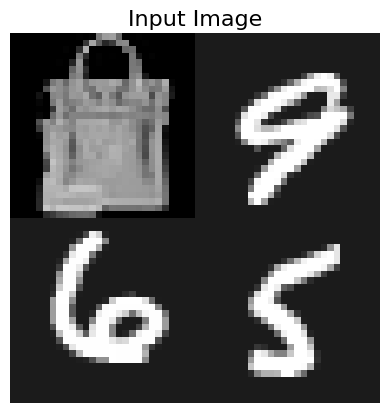

In [428]:
img = img.reshape([1, img.shape[0], img.shape[1], img.shape[2]])
act_layer = model.visualize(img)

plt.imshow(Tensor.cpu(img).numpy().reshape([img.shape[2],img.shape[3]]), cmap='gray')
plt.title('Input Image', fontsize=16)
plt.axis('off')


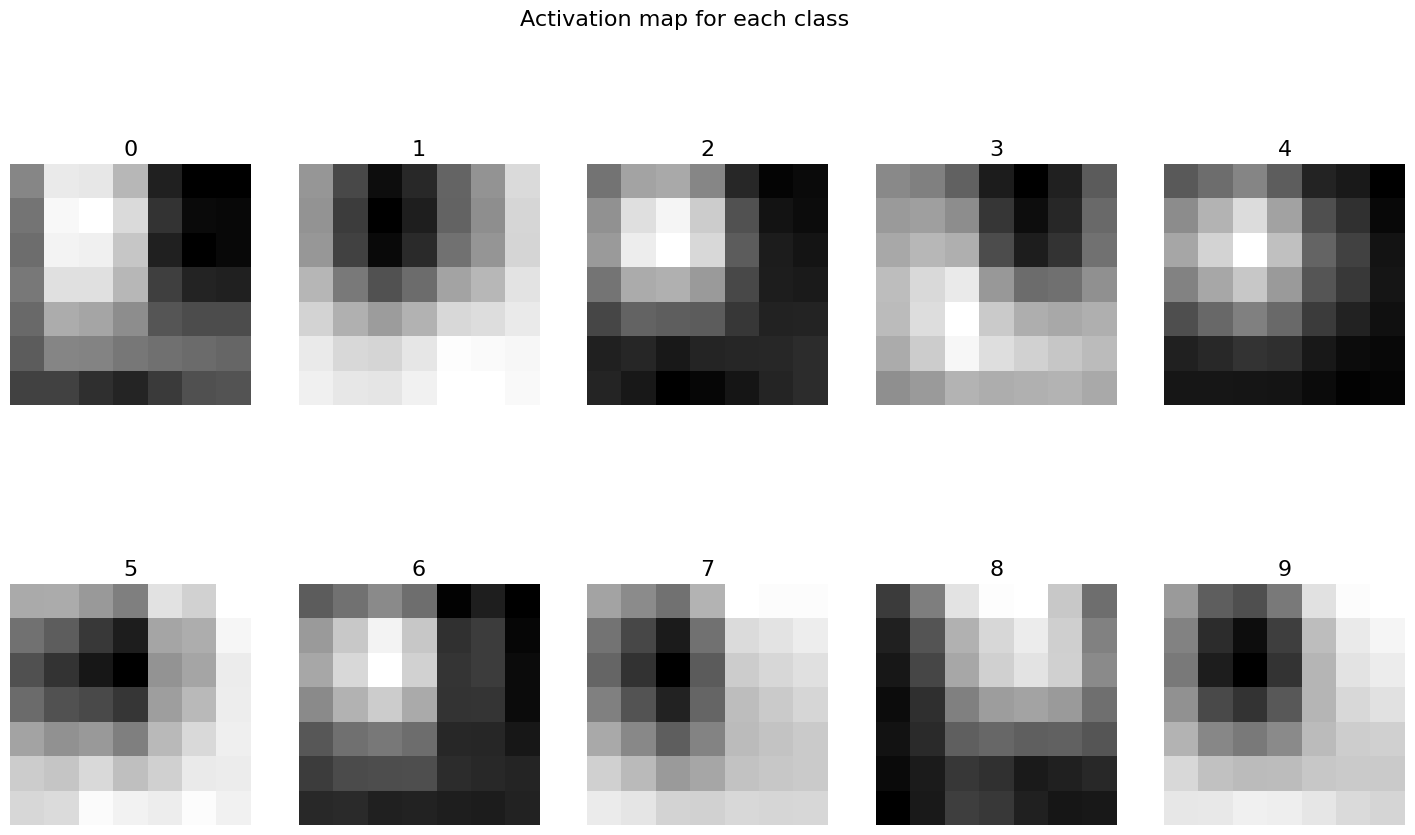

Test set Index: 0


In [462]:
f, ax = plt.subplots(2, 5)
f.suptitle("Activation map for each class", fontsize=16)
ax[0,0].imshow(Tensor.cpu(act_layer.detach()).numpy()[0][0], cmap='gray')
ax[0,0].set_title('0', fontsize=16)
ax[0,0].axis('off')

ax[0,1].imshow(Tensor.cpu(act_layer.detach()).numpy()[0][1], cmap='gray')
ax[0,1].set_title('1', fontsize=16)
ax[0,1].axis('off')

ax[0,2].imshow(Tensor.cpu(act_layer.detach()).numpy()[0][2], cmap='gray')
ax[0,2].set_title('2', fontsize=16)
ax[0,2].axis('off')

ax[0,3].imshow(Tensor.cpu(act_layer.detach()).numpy()[0][3], cmap='gray')
ax[0,3].set_title('3', fontsize=16)
ax[0,3].axis('off')

ax[0,4].imshow(Tensor.cpu(act_layer.detach()).numpy()[0][4], cmap='gray')
ax[0,4].set_title('4', fontsize=16)
ax[0,4].axis('off')

ax[1,0].imshow(Tensor.cpu(act_layer.detach()).numpy()[0][5], cmap='gray')
ax[1,0].set_title('5', fontsize=16)
ax[1,0].axis('off')

ax[1,1].imshow(Tensor.cpu(act_layer.detach()).numpy()[0][6], cmap='gray')
ax[1,1].set_title('6', fontsize=16)
ax[1,1].axis('off')

ax[1,2].imshow(Tensor.cpu(act_layer.detach()).numpy()[0][7], cmap='gray')
ax[1,2].set_title('7', fontsize=16)
ax[1,2].axis('off')

ax[1,3].imshow(Tensor.cpu(act_layer.detach()).numpy()[0][8], cmap='gray')
ax[1,3].set_title('8', fontsize=16)
ax[1,3].axis('off')

ax[1,4].imshow(Tensor.cpu(act_layer.detach()).numpy()[0][9], cmap='gray')
ax[1,4].set_title('9', fontsize=16)
ax[1,4].axis('off')

plt.gcf().set_size_inches(18, 10)
plt.show()

print(f"Test set Index: {idx}")

The network was based off of Q1 network, but instead of using linear layers, 3 convolutional layers were used instead, with the output channel being set to 128.
The hyperparameters were chosen similarly to the previous question, but then arbitarily changed until it hit the evaluation accuracy of above 80%.

Training Hyperparameters:
* Batch size = 64
* Learning Rate = $1e^{-2}$
* Decay Weight = $1e^{-8}$
* Number of Epoch = 10

Evaluation Accuracy: ~82%


## Semantic Segmentation

Besides image classification, Convolutional Neural Networks can also generate dense predictions. A popular
application is semantic segmentation. In this part, you will design and implement your Convolutional Neural
Networks to perform semantic segmentation on the Mini Facade dataset.

Mini Facade dataset consists of images of different cities around the world and diverse architectural styles
(in .jpg format), shown as the image on the left. It also contains semantic segmentation labels (in .png
format) in 5 different classes: balcony, window, pillar, facade and others. Your task is to
train a network to convert image on the left to the labels on the right

Complete the following:
1. Report the detailed architecture of your model. Include information on hyperparameters chosen for
training and a plot showing both training and validation loss across iterations. (10 pts)
2. Report the average precision on the test set. You can use provided function to calculate AP on the test
set. You should only evaluate your model on the test set once. All hyperparameter tuning should be
done on the validation set. We expect you to to achieve 0.45 AP on the test set. (10 pts)
5
3. Submit a program which contains your best combination of self.base module, optimizer and
training parameters. (5 pts)
4. Select or take a photo of any building, preprocess it as you like and input it to your best trained
model. Plot the output labels and comment qualitatively on why it works or doesn’t work. Submit
the image as input.jpg and the output labels as output.png. (5 pts) Like HW1 Part3, we
will have a contest where every student can vote for the best-labeled images. The winner will get
Extra Credits.(2 pts)

Referenced UNet: 
* https://towardsdatascience.com/creating-and-training-a-u-net-model-with-pytorch-for-2d-3d-semantic-segmentation-model-building-6ab09d6a0862
* https://github.com/jaxony/unet-pytorch/blob/master/model.py

In [156]:
N_CLASS = 5
def save_label(label, path):
    '''
    Function for ploting labels.
    '''
    colormap = [
        '#000000',
        '#0080FF',
        '#80FF80',
        '#FF8000',
        '#FF0000',
    ]
    assert(np.max(label)<len(colormap))
    colors = [hex2rgb(color, normalise=False) for color in colormap]
    w = png.Writer(label.shape[1], label.shape[0], palette=colors, bitdepth=4)
    with open(path, 'wb') as f:
        w.write(f, label)

def train(trainloader, net, criterion, optimizer, device, epoch):
    '''
    Function for training.
    '''
    start = time.time()
    running_loss = 0.0
    net = net.train()

    epoch_loss = []
    for images, labels in tqdm(trainloader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = net(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss = loss.item()

        epoch_loss.append(running_loss)
    end = time.time()
    print('[epoch %d] loss: %.3f elapsed time %.3f' %
          (epoch, running_loss, end-start))
    return epoch_loss

def test(testloader, net, criterion, device):
    '''
    Function for testing.
    '''
    losses = 0.
    cnt = 0
    epoch_loss = []
    with torch.no_grad():
        net = net.eval()
        for images, labels in tqdm(testloader):
            images = images.to(device)
            labels = labels.to(device)
            output = net(images)
            loss = criterion(output, labels)
            epoch_loss.append(loss)
            losses += loss.item()
            cnt += 1
    print(losses / cnt)
    return epoch_loss


def cal_AP(testloader, net, criterion, device):
    '''
    Calculate Average Precision
    '''
    losses = 0.
    cnt = 0
    with torch.no_grad():
        net = net.eval()
        preds = [[] for _ in range(5)]
        heatmaps = [[] for _ in range(5)]
        for images, labels in tqdm(testloader):
            images = images.to(device)
            labels = labels.to(device)
            output = net(images).cpu().numpy()
            for c in range(5):
                preds[c].append(output[:, c].reshape(-1))
                heatmaps[c].append(labels[:, c].cpu().numpy().reshape(-1))

        aps = []
        for c in range(5):
            preds[c] = np.concatenate(preds[c])
            heatmaps[c] = np.concatenate(heatmaps[c])
            if heatmaps[c].max() == 0:
                ap = float('nan')
            else:
                ap = ap_score(heatmaps[c], preds[c])
                aps.append(ap)
            print("AP = {}".format(ap))
    print(f"Average AP: {np.average(aps)}")
    # print(losses / cnt)
    return None


def get_result(testloader, net, device, folder='/part3/output_train'):
    result = []
    with torch.no_grad():
        net = net.eval()
        cnt = 0
        for images, labels in tqdm(testloader):
            images = images.to(device)
            labels = labels.to(device)
            output = net(images)[0].cpu().numpy()
            c, h, w = output.shape
            assert(c == N_CLASS)
            y = np.zeros((h,w)).astype('uint8')
            for i in range(N_CLASS):
                mask = output[i]>0.5
                y[mask] = i
            gt = labels.cpu().data.numpy().squeeze(0).astype('uint8')
            save_label(y, './{}/y{}.png'.format(folder, cnt))
            save_label(gt, './{}/gt{}.png'.format(folder, cnt))
            plt.imsave(
                './{}/x{}.png'.format(folder, cnt),
                ((images[0].cpu().data.numpy()+1)*128).astype(np.uint8).transpose(1,2,0))

            cnt += 1

In [52]:
class FacadeDataset(Dataset):
    def __init__(self, flag, dataDir='./part3/starter_set/', data_range=(0, 8), \
        n_class=5, onehot=False):
        self.onehot = onehot
        assert(flag in ['train', 'eval', 'test', 'test_dev', 'kaggle'])
        print("load "+ flag+" dataset start")
        print("    from: %s" % dataDir)
        print("    range: [%d, %d)" % (data_range[0], data_range[1]))
        self.dataset = []
        for i in range(data_range[0], data_range[1]):
            img = Image.open(os.path.join(dataDir,flag,'eecs442_%04d.jpg' % i))

            pngreader = png.Reader(filename=os.path.join(dataDir,flag,'eecs442_%04d.png' % i))
            w,h,row,info = pngreader.read()
            label = np.array(list(row)).astype('uint8')

            # Normalize input image
            img = np.asarray(img).astype("f").transpose(2, 0, 1)/128.0-1.0
            # Convert to n_class-dimensional onehot matrix
            label_ = np.asarray(label)
            label = np.zeros((n_class, img.shape[1], img.shape[2])).astype("i")
            for j in range(n_class):
                label[j, :] = label_ == j
            self.dataset.append((img, label))
        print("load dataset done")

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        img, label = self.dataset[index]
        label = torch.FloatTensor(label)
        if not self.onehot:
            label = torch.argmax(label, dim=0)
        else:
            label = label.long()

        return torch.FloatTensor(img), torch.LongTensor(label)

In [70]:
class DownBlock(nn.Module):
    def __init__(self,
            in_channels,
            out_channels,
            pooling: bool = True
            ):
        super(DownBlock, self).__init__()
        # Init Parameters
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.padding = 1
        self.pooling = pooling

        # Convolutional Layers
        self.c1 = nn.Conv2d(self.in_channels, self.out_channels, \
            kernel_size= 3, padding=1, bias=False)
        self.c2 = nn.Conv2d(self.out_channels, self.out_channels, \
            kernel_size= 3, padding=1, bias=False)

        # Pooling Layer
        if self.pooling:
            self.pool = nn.MaxPool2d(kernel_size= 2, stride= 2)

        # Normalization Layers
        self.n1 = nn.BatchNorm2d(num_features=self.out_channels)
        self.n2 = nn.BatchNorm2d(num_features=self.out_channels)

    def forward(self, x):
        x = F.relu(self.n1(self.c1(x)))
        x = F.relu(self.n2(self.c2(x)))
        bp = x
        if self.pooling:
            x = self.pool(x)
        return x, bp

class UpBlock(nn.Module):
    def __init__(self,
            in_channels,
            out_channels,
            ):
        super(UpBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        # Upsample Layer
        self.up = nn.ConvTranspose2d(in_channels, out_channels, \
            kernel_size= 2, stride=2, bias=False)

        # Convolutional Layers
        self.c1 = nn.Conv2d(in_channels= (2 * out_channels), out_channels= out_channels, \
            kernel_size= 3, padding= 1, bias=False)
        self.c2 = nn.Conv2d(in_channels= out_channels, out_channels= out_channels, \
            kernel_size= 3, padding= 1, bias=False)

        # Normalization Layers
        self.n1 = nn.BatchNorm2d(num_features=self.out_channels)
        self.n2 = nn.BatchNorm2d(num_features=self.out_channels)
        self.n3 = nn.BatchNorm2d(num_features=self.out_channels)

    def forward(self, down, up):
        up = self.n1(self.up(up))
        x = torch.cat((up,down), 1)
        x = F.relu(self.n2(self.c1(x)))
        x = F.relu(self.n3(self.c2(x)))
        return x

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.n_class = N_CLASS
        self.depth = 5
        self.down_blks = []
        self.up_blks = []
        self.in_channels = 3
        self.starting_filters = 32

        # Create Down blocks
        for i in range(self.depth):
            in_channels = self.in_channels if i == 0 else out_channels
            out_channels = self.starting_filters * (2**i)
            pooling = True if i < self.depth - 1 else False

            d_blk = DownBlock(in_channels, out_channels, pooling=pooling)
            self.down_blks.append(d_blk)

        # Create Up blocks
        for i in range(self.depth - 1):
            in_channels = out_channels 
            out_channels = in_channels // 2

            u_blk = UpBlock(in_channels, out_channels)
            self.up_blks.append(u_blk)

        self.down_blks = nn.ModuleList(self.down_blks)
        self.up_blks = nn.ModuleList(self.up_blks)

        self.output = nn.Conv2d(out_channels, self.n_class, kernel_size= 1)

        self.reset_params()

    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_normal_(m.weight)

    def reset_params(self):
        for i, m in enumerate(self.modules()):
            self.weight_init(m)

    def forward(self, x):
        down_outs = []

        for blk in self.down_blks:
            x, bp = blk(x)
            down_outs.append(bp)

        for i, blk in enumerate(self.up_blks):
            # Connect with previous down blocks
            bp = down_outs[-(i+2)]
            x = blk(bp, x)

        x = self.output(x)
        return x

The model is using the U-Net architecture and has a depth of 5, meaning there are 5 blocks used to encode then 4 blocks used to decode. Each Up block (decode) is connected to a prior Down block (encode) by having an input that was not pooled to draw back on when going forward. The hyperparameters were mostly set by the default values given as starter code. the evaluation data was taken as the last 20% of the training data. Batch size was set to 32 for the training and evaluation data sets for the reduction of training time, rather than having a batch size of 1.

Hyperparameters:
* Batch size = 32
* Learning Rate = $1e^{-3}$
* Decay Weight = $1e^{-5}$
* Number of Epoch = 10

In [157]:
device = torch.device("cpu")
name = 'U_net'
net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), 1e-3, weight_decay=1e-5)
train_data = FacadeDataset(flag='train', data_range=(0,724), onehot=False)
train_loader = DataLoader(train_data, batch_size=32)
test_data = FacadeDataset(flag='test_dev', data_range=(0,114), onehot=False)
test_loader = DataLoader(test_data, batch_size=1)
ap_data = FacadeDataset(flag='test_dev', data_range=(0,114), onehot=True)
ap_loader = DataLoader(ap_data, batch_size=1)

evaluation_data = FacadeDataset(flag='train', data_range=(724,906), onehot=False)
evaluation_loader = DataLoader(evaluation_data, batch_size=32) 

load train dataset start
    from: ./part3/starter_set/
    range: [0, 724)
load dataset done
load test_dev dataset start
    from: ./part3/starter_set/
    range: [0, 114)
load dataset done
load test_dev dataset start
    from: ./part3/starter_set/
    range: [0, 114)
load dataset done
load train dataset start
    from: ./part3/starter_set/
    range: [724, 906)
load dataset done


In [158]:
print('\nStart training')
total_loss = []
val_loss = []
for epoch in range(10):
    print('-----------------Epoch = %d-----------------' % (epoch+1))
    train_loss = train(train_loader, net, criterion, optimizer, device, epoch+1)
    test_loss = test(evaluation_loader, net, criterion, device)
    total_loss += train_loss
    val_loss += test_loss



Start training
-----------------Epoch = 1-----------------


100%|██████████| 23/23 [05:01<00:00, 13.12s/it]


[epoch 1] loss: 1.138 elapsed time 301.689


100%|██████████| 6/6 [00:27<00:00,  4.65s/it]


1.515120228131612
-----------------Epoch = 2-----------------


100%|██████████| 23/23 [05:00<00:00, 13.08s/it]


[epoch 2] loss: 0.929 elapsed time 300.807


100%|██████████| 6/6 [00:27<00:00,  4.63s/it]


1.038231372833252
-----------------Epoch = 3-----------------


100%|██████████| 23/23 [05:00<00:00, 13.08s/it]


[epoch 3] loss: 0.862 elapsed time 300.943


100%|██████████| 6/6 [00:27<00:00,  4.62s/it]


0.8705151677131653
-----------------Epoch = 4-----------------


100%|██████████| 23/23 [05:00<00:00, 13.07s/it]


[epoch 4] loss: 0.777 elapsed time 300.676


100%|██████████| 6/6 [00:27<00:00,  4.64s/it]


0.8403385976950327
-----------------Epoch = 5-----------------


100%|██████████| 23/23 [05:00<00:00, 13.08s/it]


[epoch 5] loss: 0.709 elapsed time 300.789


100%|██████████| 6/6 [00:27<00:00,  4.62s/it]


0.8309109310309092
-----------------Epoch = 6-----------------


100%|██████████| 23/23 [05:00<00:00, 13.07s/it]


[epoch 6] loss: 0.666 elapsed time 300.499


100%|██████████| 6/6 [00:27<00:00,  4.62s/it]


0.772123912970225
-----------------Epoch = 7-----------------


100%|██████████| 23/23 [05:00<00:00, 13.08s/it]


[epoch 7] loss: 0.632 elapsed time 300.764


100%|██████████| 6/6 [00:27<00:00,  4.64s/it]


0.7464031378428141
-----------------Epoch = 8-----------------


100%|██████████| 23/23 [05:00<00:00, 13.07s/it]


[epoch 8] loss: 0.608 elapsed time 300.543


100%|██████████| 6/6 [00:27<00:00,  4.62s/it]


0.6938575605551401
-----------------Epoch = 9-----------------


100%|██████████| 23/23 [05:00<00:00, 13.06s/it]


[epoch 9] loss: 0.575 elapsed time 300.497


100%|██████████| 6/6 [00:27<00:00,  4.61s/it]


0.6667851110299429
-----------------Epoch = 10-----------------


100%|██████████| 23/23 [05:00<00:00, 13.07s/it]


[epoch 10] loss: 0.552 elapsed time 300.601


100%|██████████| 6/6 [00:27<00:00,  4.63s/it]

0.6332726081212362


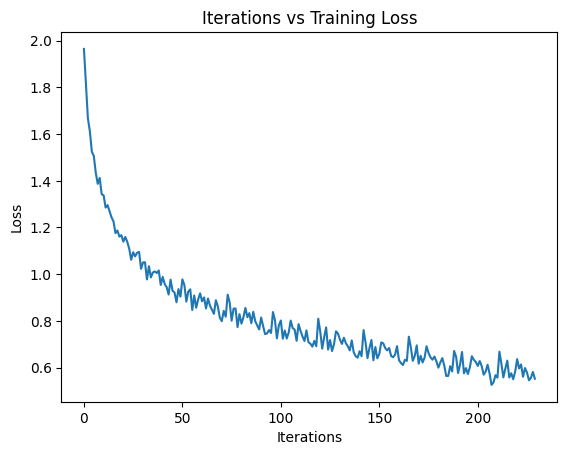

In [159]:
plt.plot(total_loss)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Iterations vs Training Loss")
plt.show()

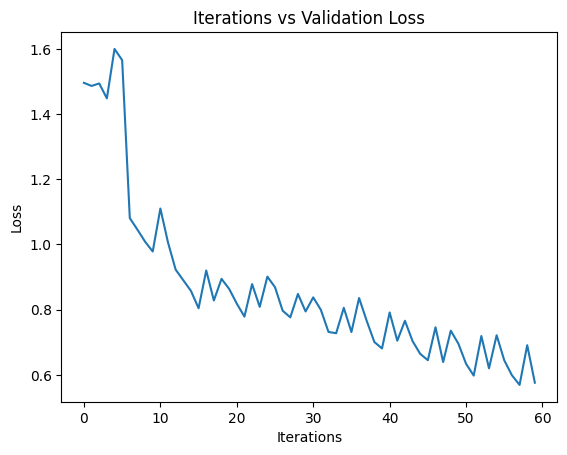

In [160]:
plt.plot(val_loss)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Iterations vs Validation Loss")
plt.show()

In [144]:
print('\nFinished Training, Testing on test set')
test(test_loader, net, criterion, device)


Finished Training, Testing on test set


100%|██████████| 114/114 [00:21<00:00,  5.30it/s]

0.7036228030920029


0.7036228030920029

In [143]:
cal_AP(ap_loader, net, criterion, device)

100%|██████████| 114/114 [00:21<00:00,  5.31it/s]


AP = 0.7033714533438625
AP = 0.8102144067937866
AP = 0.16917578910003675
AP = 0.8901711977985988
AP = 0.7126497817640007
Average AP: 0.6571165257600571


In [145]:
print('\nGenerating Unlabeled Result')
result = get_result(test_loader, net, device, folder='/part3/output_test')

torch.save(net.state_dict(), './part3/models/model_{}.pth'.format(name))


Generating Unlabeled Result


100%|██████████| 114/114 [00:27<00:00,  4.07it/s]


In [106]:
def get_seg(image, net, folder='/part3'):
    with torch.no_grad():
        net = net.eval()
        output = net(image)[0].cpu().numpy()
        c, h, w = output.shape
        assert(c == N_CLASS)
        y = np.zeros((h,w)).astype('uint8')
        for i in range(N_CLASS):
            mask = output[i]>0.5
            y[mask] = i
        save_label(y, './{}/Q3_Output.png'.format(folder))
        print("Finished Output!")

In [111]:
img = Image.open('./part3/Q3_Input.jpg')
x = transforms.functional.to_tensor(img)
x = x.unsqueeze(0)

get_seg(x, net)

Finished Output!


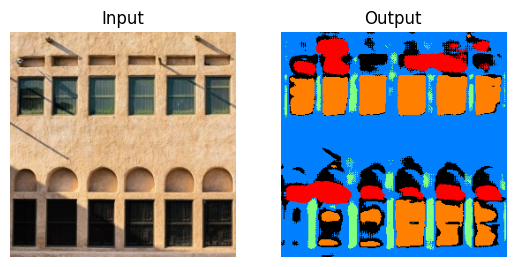

In [134]:
input = plt.imread("./part3/Q3_Input.jpg")
output = plt.imread("./part3/Q3_Output.png")

f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(input)
plt.axis("off")
plt.title("Input")
f.add_subplot(1,2, 2)
plt.imshow(output)
plt.axis("off")
plt.title("Output")
plt.show(block=True)

All the top windows were labeled correctly, but the bottom left was hard to recognize, most likely due to the shadowing. The output could have been better if the image was better normalized. The stylized indents should have been black, which some are labeled correctly, but most are recognized as red (balcony). This is most likely due to the model not having been trained to recognized this specific feature. This feature is from an Arabic house, so it might not align with the given dataset to train on. Another issue was that the facade inbetween the windows is being labeled as pillars. What caused this is probably the depth of the darkness of the adjacent windows. It's very apparent that the dark windows makes the inbetween seem like pillars to the model.